In [98]:
import pacepredictor as pp
import importlib
import plotly.express as px
import pandas as pd
import numpy as np
import missingno as msno
import math
import statsmodels.formula.api as smf

display_big_figures = False

importlib.reload(pp)

<module 'pacepredictor' from '/home/adam/projects/Concept2-Pace-Predictor/pacepredictor.py'>

# Predictor

Create a regression model to predict 2000m time.

# Load Data

In [99]:
file_path = "../Concept2-Logbook-Scraper/analysis/"
file_name = "rowing_cleaned_data.csv"

pp_row = pp.Predictor(f"{file_path}{file_name}", random_state=42)

pp_row.df = pp_row.df.drop("profile_id", axis = 1)

pp_row.df

result_1  result_100  result_1000  result_10000  result_100000  \
0           NaN         NaN        255.9           NaN            NaN   
1           NaN         NaN          NaN           NaN            NaN   
2         330.0         NaN          NaN           NaN            NaN   
3           NaN         NaN        203.9        2222.6            NaN   
4           NaN         NaN        236.3        2512.3            NaN   
...         ...         ...          ...           ...            ...   
60688       NaN         NaN          NaN           NaN            NaN   
60689       NaN         NaN        230.4           NaN            NaN   
60690       NaN         NaN        177.0           NaN            NaN   
60691       NaN         NaN          NaN        3202.8            NaN   
60692       NaN         NaN          NaN        2571.6            NaN   

       result_2000  result_21097  result_30  result_4  result_42195  \
0              NaN           NaN        NaN       NaN           NaN   
1              NaN           NaN        NaN       NaN           NaN   
2              NaN        5688.1        NaN       NaN           NaN   
3            416.4           NaN     8215.0       NaN           NaN   
4            474.1           NaN     7289.0    1031.0           NaN   
...            ...           ...        ...       ...           ...   
60688          NaN           NaN        NaN       NaN           NaN   
60689          NaN           NaN        NaN       NaN           NaN   
60690          NaN           NaN        NaN       NaN           NaN   
60691          NaN           NaN        NaN       NaN           NaN   
60692          NaN           NaN        NaN       NaN           NaN   

       result_500  result_5000  result_60  result_6000  \
0             NaN          NaN        NaN          NaN   
1           116.0          NaN        NaN          NaN   
2             NaN          NaN        NaN       1498.0   
3            94.6       1086.8    16144.0       1307.6   
4           107.4       1204.7        NaN       1485.8   
...           ...          ...        ...          ...   
60688         NaN       1304.7        NaN          NaN   
60689         NaN          NaN        NaN          NaN   
60690         NaN          NaN        NaN          NaN   
60691         NaN          NaN        NaN          NaN   
60692         NaN          NaN        NaN          NaN   

      adaptive_rowing_category  age  height  weight weight_class gender  
0                         able   67     NaN    64.9            H      F  
1                         able   62     NaN    72.6            H      F  
2                         able   65   172.7    99.8            H      M  
3                         able   56   188.0    97.1            H      M  
4                         able   67     NaN    86.2            H      M  
...                        ...  ...     ...     ...          ...    ...  
60688                     able   46     NaN     NaN            H      M  
60689                     able   17     NaN     NaN            H      F  
60690                     able   22     NaN     NaN            H      M  
60691                     able   38     NaN     NaN            H      F  
60692                     able   43   185.4    86.2            H      M  

[60693 rows x 20 columns]

# Missing Data

In [100]:
pp.percent_complete(pp_row.df)

result_1                     14.393752
result_100                   10.024220
result_1000                  25.121513
result_10000                 32.926367
result_100000                 0.301517
result_2000                  43.479479
result_21097                 13.706688
result_30                    35.368164
result_4                      7.556061
result_42195                  4.384361
result_500                   21.598866
result_5000                  46.021782
result_60                    11.767420
result_6000                  16.252286
adaptive_rowing_category    100.000000
age                         100.000000
height                       50.971282
weight                       56.077307
weight_class                100.000000
gender                      100.000000
dtype: float64


<AxesSubplot:>

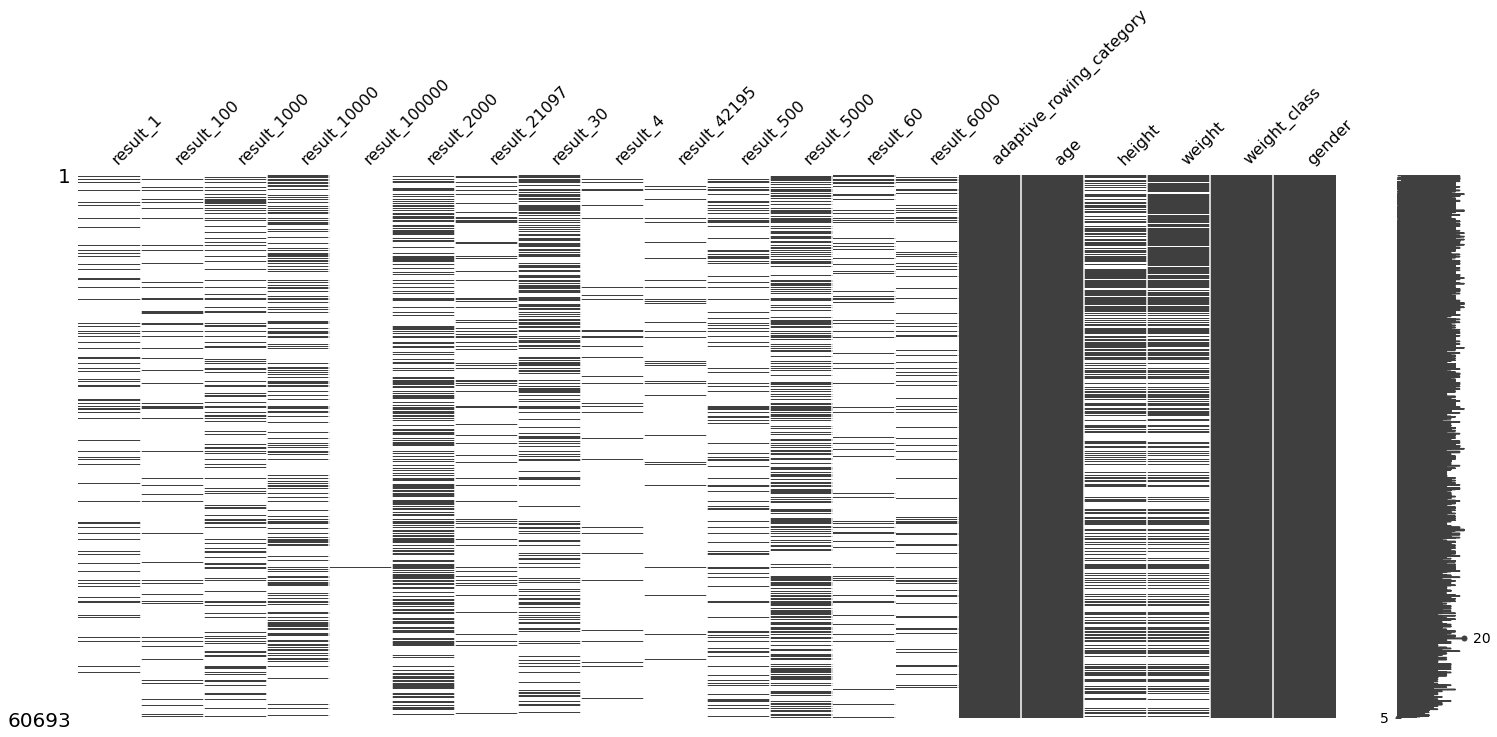

In [101]:
msno.matrix(pp_row.df)

Lots of event results missing, and lots of height and weight missing. Is this data missing randomly or is there a correlation?

<AxesSubplot:>

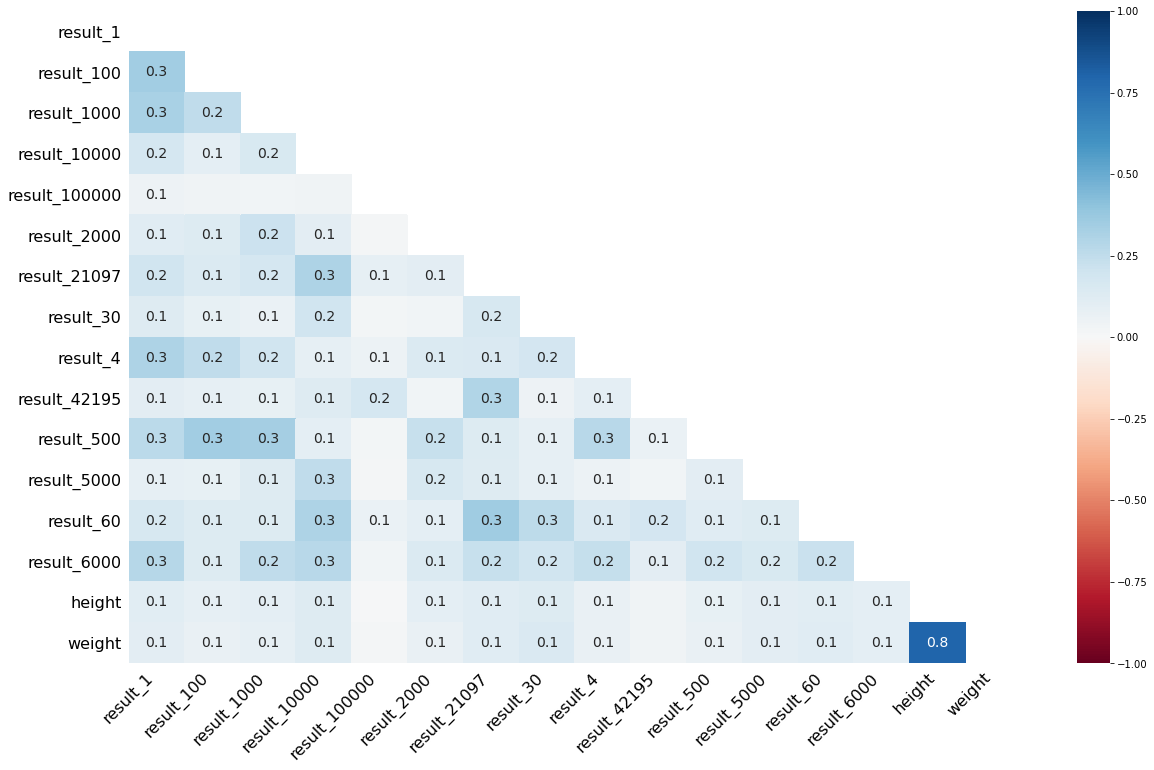

In [102]:
msno.heatmap(pp_row.df)

The missing results are poorly correlated both with other results and with height and weight. Missing results means that the athlete has not recorded a result for this workout. This looks like we can treat this is MCAR (missing completely at random) data. We will drop missing results initially as I don't think imputing will yield good results and there will still be a good amount of data to work with.

Height and weight are highly correlated to eachother in their missingness, but this makes sense given that it is user input from the same web form. We only have about 50% height and weight data, which might be enough to get reasonable imputation, but we will also have plenty of data left if we drop the missing height and weight rows - we will take the later approach initially.

# Visualise Data Distribution

In [103]:
fig = pp_row.plot_distributions(cols =4)
#fig = pp_row.plot_distributions(cols = 7, width=4000, height=2000)
if display_big_figures:
    fig.show()

# Further Cleaning

1. Cut off results at maximum at current men's 30-39 world record (usually the fastest time)

In [104]:
distance_row_world_records = {
    100:12.6,
    500:70.5,
    1000:159.5,
    2000:336.6,
    5000:898.3,
    6000:1096.8,
    10000:1865.2,
    21097:4042.7,
    42195:8668.1
}

time_row_world_records = {
    1:430,
    4:1412,
    30:9449,
    60:18602
}


for event, record in distance_row_world_records.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x > record else np.nan)

for event, record in time_row_world_records.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x < record else np.nan)

2. Cut off anything slower than 3:00.0 / 500m pace

In [105]:
distance_events_slow = {
    100:0,
    500:0,
    1000:0,
    2000:0,
    5000:0,
    6000:0,
    10000:0,
    21097:0,
    42195:0
}

time_events_slow = {
    1:0,
    4:0,
    30:0,
    60:0
}


#3:00.0 = 180 seconds
slow_cut_off_pace = 180

for event in distance_events_slow:
    distance_events_slow[event] = event/500 * slow_cut_off_pace

for event, slow_pace in distance_events_slow.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x < slow_pace else np.nan)

for event in time_events_slow:
    time_events_slow[event] = (event*60)/slow_cut_off_pace * 500

for event, slow_pace in time_events_slow.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x > slow_pace else np.nan)

3. Include only able-bodied athletes in this model as we do not have enough para-athletes


In [106]:
indexes_to_drop = pp_row.df[pp_row.df["adaptive_rowing_category"] != "able"].index
pp_row.df.drop(indexes_to_drop, inplace=True)
pp_row.df.drop("adaptive_rowing_category", axis=1, inplace=True)

4. Drop height and weight outliers - most likely errors on form entry

In [107]:
max_height = 209
min_height = 150
max_weight = 150
min_weight = 45

indexes_to_drop = []
indexes_to_drop += pp_row.df[pp_row.df["height"] > max_height].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["height"] < min_height].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["weight"] > max_weight].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["weight"] < min_weight].index.to_list()

pp_row.df.drop(indexes_to_drop, inplace=True)

In [108]:
fig = pp_row.plot_distributions(cols = 4)
if display_big_figures:
    fig.show()

 # Visualisation
 
 Visualise the target against other variables

In [109]:
target = "result_2000"
cont_parameters = pp_row.df.columns.drop([target, "weight_class", "gender"]).to_list()
fig = pp_row.plot_scatters(target, cont_parameters, cols=4)
if display_big_figures:
    fig.show()
# plotly.io.write_image(fig, 'scatters.pdf', format='pdf')

In [110]:
target = "result_2000"
cat_parameters = ["weight_class", "gender"]
fig = pp_row.plot_violins(target, cat_parameters, cols=2, height=1000)
if display_big_figures:
    fig.show()

# Cleaning Complete

Write this data to a file for use later.

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2260.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:29   Log-Likelihood:                -8027.9
No. Observations:                1787   AIC:                         1.607e+04
Df Residuals:                    1781   BIC:                         1.610e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     157.8791     15.918      9.918      

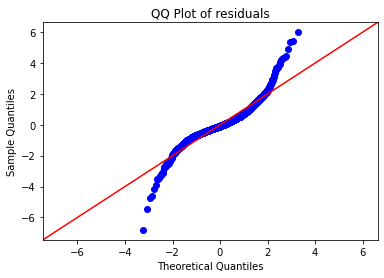

Max p: gender[T.M] p=0.003


In [131]:
model_name = "Linear_1000m_only"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=1, drop=["result_1"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

## 3rd Order

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     805.3
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:32   Log-Likelihood:                -7971.8
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1771   BIC:                         1.606e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4212.8165   1770.448     -2.380

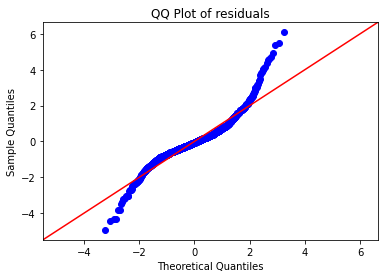

Max p: gender[T.M] p=0.196


In [140]:
model_name = "3rd_order_2"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()



                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     862.4
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:33   Log-Likelihood:                -7972.7
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1772   BIC:                         1.606e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4175.4582   1770.550     -2.358

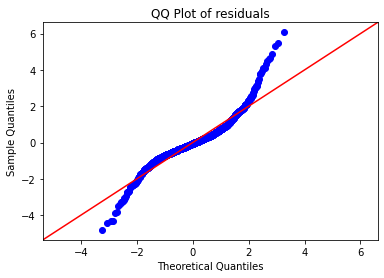

Max p: result_1 p=0.131


In [141]:
model_name = "3rd_order_3"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000", "gender"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     927.9
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:34   Log-Likelihood:                -7973.8
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1773   BIC:                         1.605e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4145.0685   1771.077     -2.340

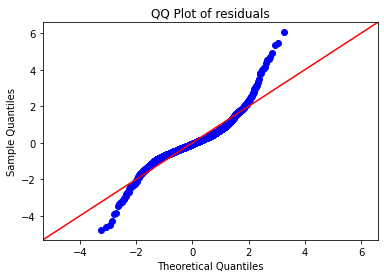

Max p: weight p=0.055


In [142]:
model_name = "3rd_order_3"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000", "gender", "result_1"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1003.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:34   Log-Likelihood:                -7975.7
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1774   BIC:                         1.605e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3818.8688   1764.270     -2.165

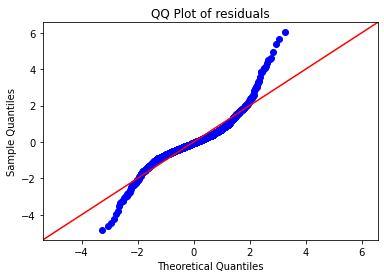

Max p: weight_3 p=0.396


In [143]:
model_name = "3rd_order_4"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000", "gender", "result_1", "weight"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1095.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:35   Log-Likelihood:                -7976.0
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1775   BIC:                         1.604e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3757.3739   1762.645     -2.132

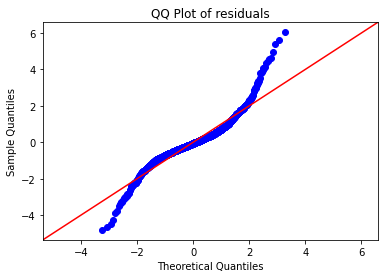

Max p: Intercept p=0.033


In [144]:
model_name = "3rd_order_5"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000", "gender", "result_1", "weight", "weight_3"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

                                 OLS Regression Results                                
Dep. Variable:            result_2000   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          8.294e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                        0.00
Time:                        20:59:35   Log-Likelihood:                         -7978.3
No. Observations:                1787   AIC:                                  1.598e+04
Df Residuals:                    1776   BIC:                                  1.604e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

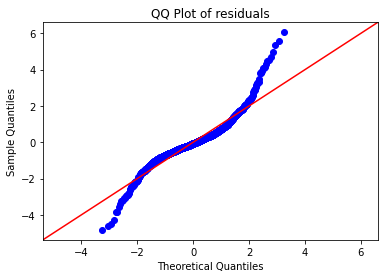

Max p: age p=0.005


In [145]:
model_name = "3rd_order_6"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000", "gender", "result_1", "weight", "weight_3"], intercept=False)
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()



                                 OLS Regression Results                                
Dep. Variable:            result_2000   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          9.089e+04
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                        0.00
Time:                        20:59:36   Log-Likelihood:                         -7982.2
No. Observations:                1787   AIC:                                  1.598e+04
Df Residuals:                    1777   BIC:                                  1.604e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

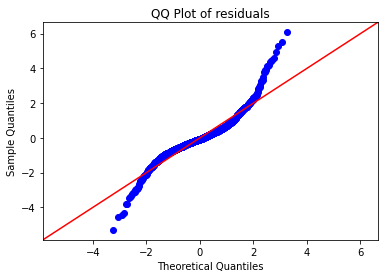

Max p: age_2 p=0.225


In [146]:
model_name = "3rd_order_7"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=3, drop=["result_1000", "gender", "result_1", "weight", "weight_3", "age"], intercept=False)
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

# Is this an improvement on just using a single result?

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     4378.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:36   Log-Likelihood:                -8702.3
No. Observations:                1787   AIC:                         1.741e+04
Df Residuals:                    1785   BIC:                         1.742e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    887.7898      6.307    140.764      0.0

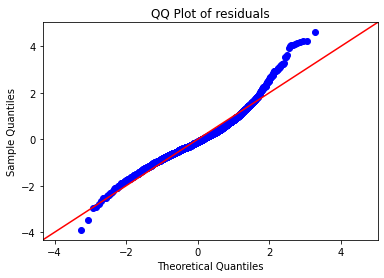

Max p: Intercept p=0.0


In [147]:
model_name = "single_parameter_test"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=1, drop=["result_1000", "age", "height", "weight", "gender"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

In [148]:
import plotly.graph_objects as go

pp_row.models[model_name].df_train = pp_row.models[model_name].df_train.sort_values(by="result_1")

pp_row.models[model_name].df_train["predict"] = pp_row.models[model_name].model.predict(pp_row.models[model_name].df_train)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pp_row.df_train["result_1"], y=pp_row.df_train["result_2000"], name="scatter_name", mode="markers"))

fig.add_trace(go.Scatter(
     x=pp_row.models[model_name].df_train["result_1"], y=pp_row.models[model_name].df_train["predict"], name="line_name"))

fig.update_layout(title="title", xaxis_title="x_title",
    yaxis_title="y_title")

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     2270.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:37   Log-Likelihood:                -8678.8
No. Observations:                1787   AIC:                         1.736e+04
Df Residuals:                    1784   BIC:                         1.738e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1123.4169     34.708     32.368      0.0

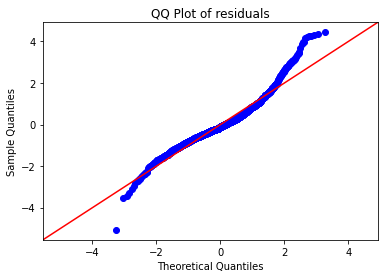

Max p: result_1_2 p=0.0


In [149]:
model_name = "single_parameter_test_2nd"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model(model_name, target, parameters, order=2, drop=["result_1000", "age", "height",	"weight", "gender", "result_1000_2", "age_2", "height_2",	"weight_2"])
print(pp_row.models[model_name].model.summary())
print(f"Mean squared error: {round(pp_row.models[model_name].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models[model_name].mse),1)}s")
fig = pp_row.models[model_name].plot_residuals()
fig.show()
pp_row.models[model_name].plot_QQ()
pp_row.models[model_name].anova()
pp_row.models[model_name].p_max()

In [150]:

pp_row.models[model_name].df_train = pp_row.models[model_name].df_train.sort_values(by="result_1")

pp_row.models[model_name].df_train["predict"] = pp_row.models[model_name].model.predict(pp_row.models[model_name].df_train)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pp_row.df_train["result_1"], y=pp_row.df_train["result_2000"], name="scatter_name", mode="markers"))

fig.add_trace(go.Scatter(
     x=pp_row.models[model_name].df_train["result_1"], y=pp_row.models[model_name].df_train["predict"], name="line_name"))

fig.update_layout(title="title", xaxis_title="x_title",
    yaxis_title="y_title")